# <!-- TITLE --> [SYNOP2] - First predictions at 3h
<!-- DESC --> Episode 2 : RNN training session for weather prediction attempt at 3h
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

run_dir = './run/SYNOP'
datasets_dir = 'fidle-datasets'

In [2]:
from IPython.display import Markdown
def subtitle(t):
    display(Markdown(f'<br>**{t}**'))

### 1.2 - Parameters

In [3]:
# ---- About dataset (no need to change)
#
dataset_dir      = './data'                  # Enhanced dataset is very small, so ./data in a good choice :-)
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training (Can be changed !)
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 16
batch_size       = 32
epochs           = 10
fit_verbosity    = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [4]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)

<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00
mean,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.79,-1.59,-1.74,-1.36,-5.22,-3.85,-0.53,-4.97,-1.62,-0.32,-0.27,-3.04
25%,-0.63,-0.85,-0.62,-0.75,-0.72,-0.68,-0.42,-0.55,-0.69,-0.16,-0.20,-0.75
50%,-0.00,-0.48,-0.11,-0.19,0.04,0.21,-0.42,0.04,-0.29,-0.16,-0.20,-0.01
75%,0.63,0.99,1.10,0.50,0.77,0.82,-0.37,0.62,0.51,-0.16,-0.20,0.71
max,7.14,1.36,1.35,6.24,2.44,1.59,4.45,3.08,6.25,29.82,31.17,3.07


<br>**Shapes :**

Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


### 2.2 - Prepare data generator

In [8]:
# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
subtitle('What a batch looks like (x) :')
print(x[0])
subtitle('What a batch looks like (y) :')
print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  729
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


<br>**What a batch looks like (x) :**

[[-1.08700214  0.62339201 -1.74260306 -1.36124989 -0.21151629  0.92788234
   2.5537085  -3.53335969 -0.5548422  -0.15628743 -0.19911541 -0.62411123]
 [-1.35836112  0.62339201 -1.22653564 -0.9568005  -0.22850619  1.20563932
   2.60504167 -3.73327595 -0.94615102  0.16956189  0.21907938 -0.73495229]
 [ 0.08888678 -0.48190581  0.66571156 -0.51190618 -0.19452639  1.31674211
   2.45104217 -3.7199482  -0.94615102 -0.15628743  0.07968112 -0.75958364]
 [ 2.07885263 -0.48190581  0.92374527 -0.30968148 -0.1435567   1.3722935
   2.04037682 -3.41340993 -0.13744613 -0.15628743  1.89185857 -0.73495229]
 [ 2.5311176  -1.21877102  1.09576774  0.4992173  -0.31345568  1.26119071
   0.55171495 -3.04023291  0.6451715   0.49541121  0.35847765 -0.82116201]
 [ 4.34017747 -0.48190581  1.26779022  0.70144199 -0.51733445  1.09453653
   2.5537085  -2.40050088  0.51473523  0.16956189  0.07968112 -0.90737172]
 [ 4.79244244 -0.85033841  1.26779022 -0.10745679 -1.01004149  0.65012537
   0.55171495 -1.69413009  0.2538

<br>**What a batch looks like (y) :**

[ 0.17933977 -1.21877102  0.57970032 -0.75457581 -2.06341517  0.65012537
 -0.42361524  0.6648818  -1.23311082 -0.15628743 -0.19911541 -1.92957264]


## Step 3 - Create a model

In [9]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               45200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12)                1212      
                                                                 
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


## Step 4 - Compile and train

### 4.1 - Callback

In [11]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [12]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit

In [13]:
history=model.fit(train_generator, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

Epoch 1/10
729/729 [==============================] - 8s 9ms/step - loss: 0.6134 - mae: 0.5135 - val_loss: 0.4893 - val_mae: 0.4300
Epoch 2/10
729/729 [==============================] - 6s 9ms/step - loss: 0.5110 - mae: 0.4441 - val_loss: 0.4654 - val_mae: 0.4058
Epoch 3/10
729/729 [==============================] - 6s 9ms/step - loss: 0.4839 - mae: 0.4228 - val_loss: 0.4565 - val_mae: 0.3990
Epoch 4/10
729/729 [==============================] - 6s 9ms/step - loss: 0.4685 - mae: 0.4117 - val_loss: 0.4426 - val_mae: 0.3896
Epoch 5/10
729/729 [==============================] - 6s 8ms/step - loss: 0.4568 - mae: 0.4028 - val_loss: 0.4365 - val_mae: 0.3927
Epoch 6/10
729/729 [==============================] - 6s 9ms/step - loss: 0.4491 - mae: 0.3979 - val_loss: 0.4300 - val_mae: 0.3761
Epoch 7/10
729/729 [==============================] - 6s 9ms/step - loss: 0.4428 - mae: 0.3930 - val_loss: 0.4266 - val_mae: 0.3705
Epoch 8/10
729/729 [==============================] - 6s 9ms/step - loss: 0.

In [14]:
import pandas as pd
df=pd.DataFrame(data=history.history)
display(df)

,loss,mae,val_loss,val_mae
0,0.613446,0.513479,0.489266,0.429956
1,0.511001,0.444068,0.465360,0.405788
2,0.483882,0.422754,0.456454,0.399042
3,0.468523,0.411721,0.442590,0.389607
4,0.456766,0.402759,0.436466,0.392746
5,0.449075,0.397933,0.430021,0.376052
6,0.442830,0.393021,0.426597,0.370459
7,0.437337,0.390517,0.442585,0.389201
8,0.431504,0.388836,0.434669,0.370326
9,0.430523,0.387139,0.426639,0.370900


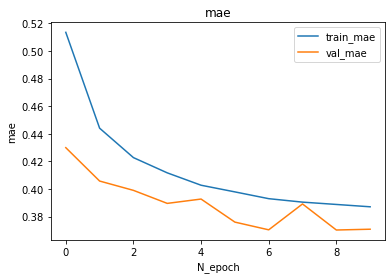

In [15]:
plt.figure()
plt.plot(df['mae'],label='train_mae')
plt.plot(df['val_mae'],label='val_mae')
plt.title("mae")
plt.xlabel('N_epoch')
plt.ylabel('mae')
plt.legend()

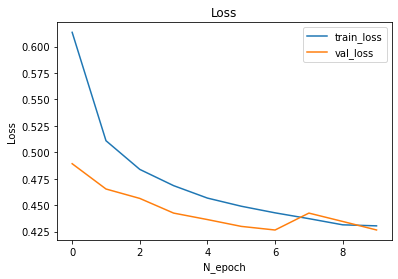

In [17]:
plt.figure()
plt.plot(df['loss'],label='train_loss')
plt.plot(df['val_loss'],label='val_loss')
plt.title("Loss")
plt.xlabel('N_epoch')
plt.ylabel('Loss')
plt.legend()

## Step 5 - Predict

### 5.1 - Load model

In [18]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/best_model.h5')

### 5.2 Make a prediction
A basic prediction, with normalized values (so humanly not very understandable)

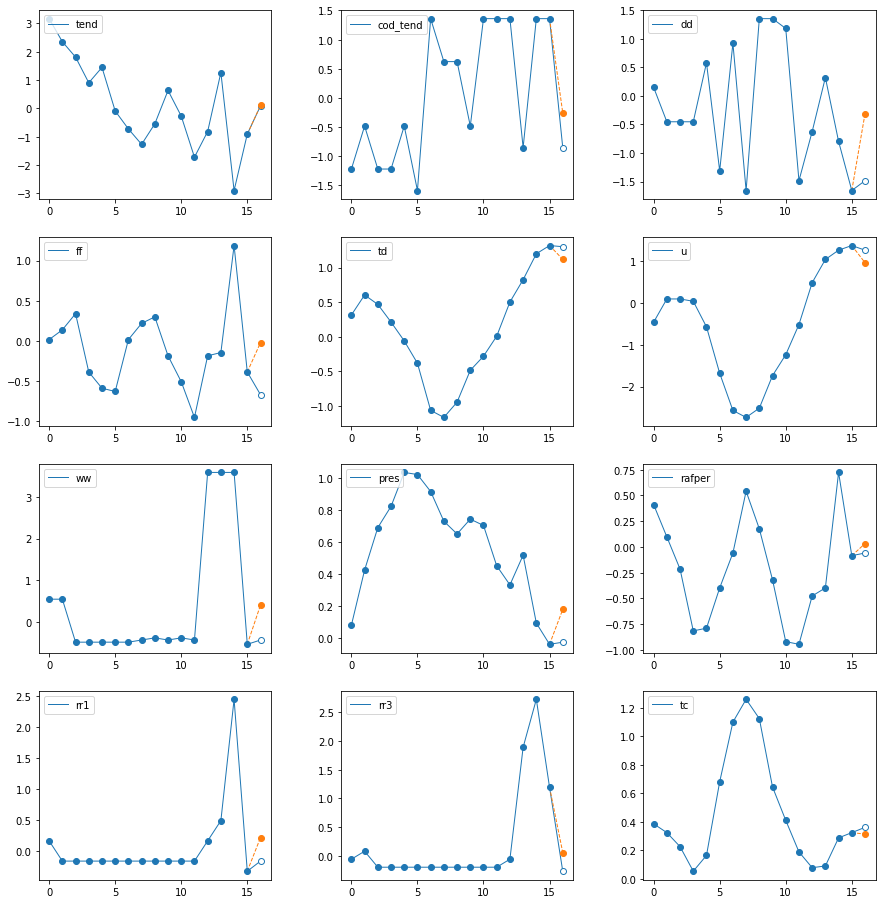

In [22]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result

def plot_multivariate_serie(sequence, labels=None, predictions=None, only_features=None,
                            columns=3, width=5,height=4,wspace=0.3,hspace=0.2,ms=6,lw=1,
                            time_dt=1, hide_ticks=False):
    
    sequence_len = len(sequence)
    features_len = sequence.shape[1]
    if only_features is None : only_features=range(features_len)
    if labels is None        : labels=range(features_len)
    
    t  = np.arange(sequence_len)    
    if predictions is None:
        dt = 0
    else:
        dt = len(predictions)
        sequence_with_pred = sequence.copy()
        sequence_with_pred[-dt:]=predictions

    rows = math.ceil(features_len/columns)
    fig  = plt.figure(figsize=(columns*width, rows*height))
    fig.subplots_adjust(wspace=0.3,hspace=0.2)
    n=1
    for i in only_features:
        ax=fig.add_subplot(rows, columns, n)
        
        # ---- Real sequence without prediction
        #
        ax.plot( t[:-dt],sequence[:-dt,i], 'o',  markersize=ms, color='C0', zorder=2)
        ax.plot( t,sequence[:,i],          '-',  linewidth=lw,  color='C0', label=labels[i],zorder=1)

        # ---- What we expect
        #
        ax.plot(t[-dt:], sequence[-dt:,i], 'o', markeredgecolor='C0',markerfacecolor='white',ms=6)
        
        if predictions is not None:
            ax.plot(t[-dt-1:], sequence_with_pred[-dt-1:,i], '--',  lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=1)
            ax.plot(t[-dt:],   predictions[:,i],             'o',   lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=2)

        if hide_ticks:
            ax.set_yticks([])
            ax.set_xticks([])
        
        ax.legend(loc="upper left")
        n+=1    
    plt.show()

plot_multivariate_serie(sequence_true, predictions=pred, labels=features)

### 5.3 Real prediction
We are now going to make a true prediction, with an un-normalized result

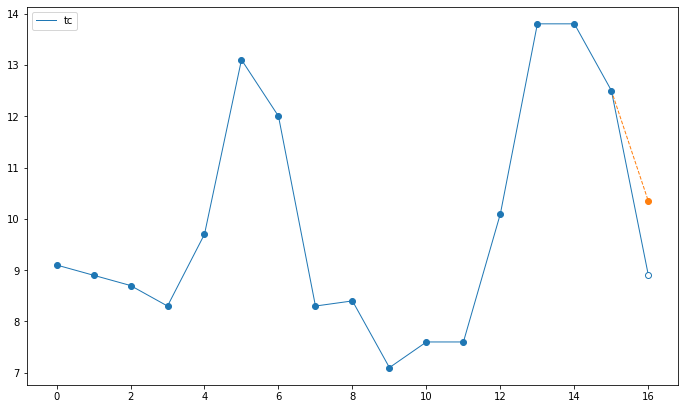

Gap between prediction and reality : 1.44 °C


In [36]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8)

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')
